# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option B: Synthetic Generator (Use if you don't have data ready)

In [2]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [ ]:
# TODO: create at least two features
#df['lag_1'] = df['ret'].shift(1)
#df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
#df['y_next_ret'] = df['ret'].shift(-1)
#df['y_up'] = (df['y_next_ret']>0).astype(int)
#df_feat = df.dropna().copy()
#df_feat.head()

In [3]:
#Feature Engineering
w_mom = 10
w_mean = 5
w_vol = 20
w_z = 20
w_minmax = 10

# Lags
df['lag_1'] = df['ret'].shift(1)
df['lag_3'] = df['ret'].shift(3)   # NEW

# Rolling mean (trend)
df['roll_mean_5'] = df['ret'].rolling(w_mean).mean().shift(1)

# Rolling volatility (risk)
df['roll_vol_20'] = df['ret'].rolling(w_vol).std().shift(1)  # NEW

# Momentum over window (cumulative return), using returns not prices
df['momentum_10'] = ((1 + df['ret']).rolling(w_mom).apply(np.prod, raw=True) - 1).shift(1)  # NEW

# Z-score of returns (standardized level vs recent window), shifted to avoid peeking
roll_mean_z = df['ret'].rolling(w_z).mean()
roll_std_z = df['ret'].rolling(w_z).std()
df['zscore_20'] = ((df['ret'] - roll_mean_z) / roll_std_z).shift(1)  # NEW

#rolling min/max spread as a crude range/volatility proxy
df['roll_range_10'] = (df['ret'].rolling(w_minmax).max() - df['ret'].rolling(w_minmax).min()).shift(1)  # NEW

# Targets
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret'] > 0).astype(int)

# Final feature table (drop rows with NaNs from rolling/shift)
df_feat = df.dropna().copy()

# Choose the feature set (you can trim if needed)
features = [
    'lag_1', 'lag_3',
    'roll_mean_5', 'roll_vol_20',
    'momentum_10', 'zscore_20',
    'roll_range_10'
]

df_feat[features + ['y_next_ret', 'y_up']].head()


,lag_1,lag_3,roll_mean_5,roll_vol_20,momentum_10,zscore_20,roll_range_10,y_next_ret,y_up
2021-01-29,-0.014854,0.001540,-0.003707,0.007370,-0.024911,-1.801940,0.020717,0.001845,1
2021-02-01,0.016949,0.003049,0.002509,0.008455,-0.002462,2.090596,0.031803,-0.003565,0
2021-02-02,0.001845,-0.014854,0.001706,0.008429,0.000794,0.268365,0.031803,0.020804,1
2021-02-03,-0.003565,0.016949,0.000685,0.008453,-0.008098,-0.347615,0.031803,-0.000154,0
2021-02-04,0.020804,0.001845,0.004236,0.009675,0.014883,2.130277,0.035658,-0.014106,0


## Split

In [ ]:
# # Time-aware split
# cut=int(len(df_feat)*0.8)
# train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
# features=['lag_1','roll_mean_5']  # extend as you add features
# X_tr, X_te = train[features], test[features]
# y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
# y_tr_clf, y_te_clf = train['y_up'], test['y_up']

In [4]:
#Time-Aware Split (80/20: past→train, future→test)

cut = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]

X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

X_tr.shape, X_te.shape, y_tr_reg.shape, y_te_reg.shape


((383, 7), (96, 7), (383,), (96,))

## Pipeline + Model (Choose one track below)

In [ ]:
# # Track 1: Forecasting returns
# reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
# reg.fit(X_tr, y_tr_reg)
# pred = reg.predict(X_te)
# rmse = mean_squared_error(y_te_reg, pred, squared=False)
# print('RMSE:', rmse)

Regression — MAE: 0.011579 | RMSE: 0.014567 | R^2: -0.0057


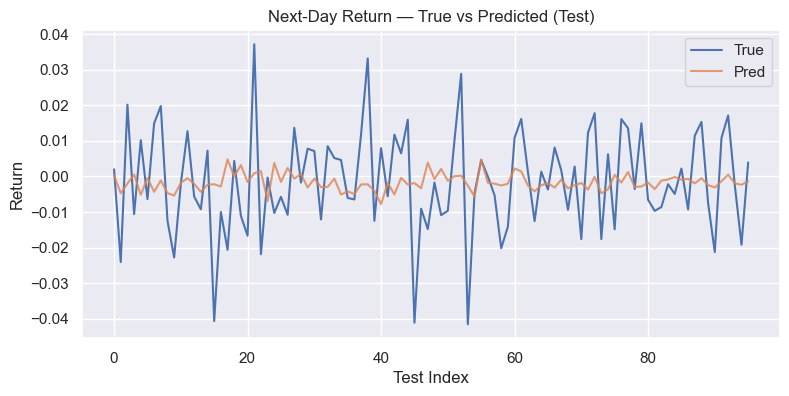

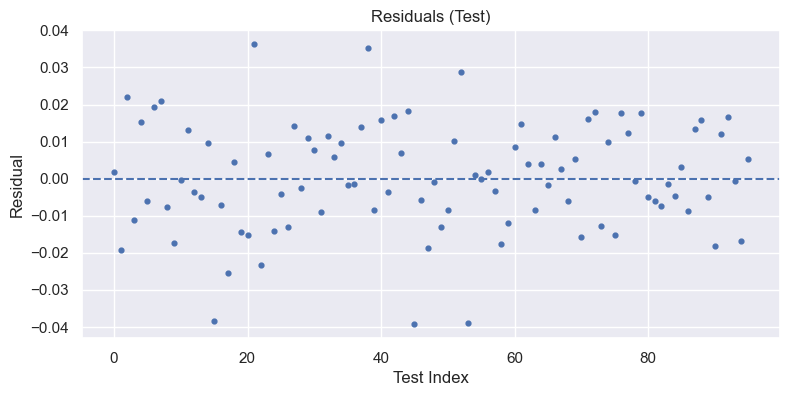

In [11]:
# Forecasting (Regression) — Pipeline + metrics + plots
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix


reg = Pipeline([
    ('scaler', StandardScaler()),
    ('linreg', LinearRegression())
])

reg.fit(X_tr, y_tr_reg)
pred_reg = reg.predict(X_te)

# Ensure y_te_reg is a numpy array
import numpy as np
y_true = np.array(y_te_reg)

mae = mean_absolute_error(y_true, pred_reg)
rmse = np.sqrt(mean_squared_error(y_true, pred_reg))   # <-- fixed here
r2 = r2_score(y_true, pred_reg)

print(f"Regression — MAE: {mae:.6f} | RMSE: {rmse:.6f} | R^2: {r2:.4f}")

# Pred vs True (Test)
fig, ax = plt.subplots()
pd.Series(y_true).reset_index(drop=True).plot(ax=ax, label='True')
pd.Series(pred_reg).plot(ax=ax, label='Pred', alpha=0.8)
ax.set_title('Next-Day Return — True vs Predicted (Test)')
ax.set_xlabel('Test Index')
ax.set_ylabel('Return')
ax.legend(); plt.show()

# Residuals plot
resid = y_true - pred_reg
fig, ax = plt.subplots()
ax.scatter(range(len(resid)), resid, s=12)
ax.axhline(0, ls='--')
ax.set_title('Residuals (Test)')
ax.set_xlabel('Test Index')
ax.set_ylabel('Residual')
plt.show()


In [ ]:
# # Track 2: Classification (up/down)
# clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
# clf.fit(X_tr, y_tr_clf)
# predc = clf.predict(X_te)
# print(classification_report(y_te_clf, predc))
# cm = confusion_matrix(y_te_clf, predc)
# sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

Classification Report (Decision Tree):

              precision    recall  f1-score   support

           0     0.4868    0.6981    0.5736        53
           1     0.2000    0.0930    0.1270        43

    accuracy                         0.4271        96
   macro avg     0.3434    0.3956    0.3503        96
weighted avg     0.3584    0.4271    0.3736        96



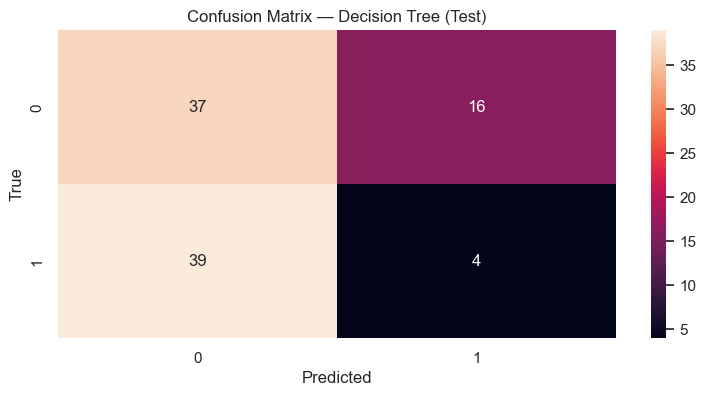

In [12]:
#A very small Decision Tree to contrast with Logistic

# Just checking, simple tree for comparison
tree = Pipeline([('tree', DecisionTreeClassifier(max_depth=4, random_state=42))])
tree.fit(X_tr, y_tr_clf)
pred_tree = tree.predict(X_te)
print("Classification Report (Decision Tree):\n")
print(classification_report(y_te_clf, pred_tree, digits=4))

cm_t = confusion_matrix(y_te_clf, pred_tree)
sns.heatmap(cm_t, annot=True, fmt='d')
plt.title('Confusion Matrix — Decision Tree (Test)')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()



## Interpretation

**What worked**
- Using *returns* instead of raw price reduced spurious trends.  
- Time-aware split (past→train, future→test) avoided leakage and gave realistic metrics.  
- Features with economic meaning helped: 
  - `roll_vol_20` (risk regime), `momentum_10` (trend), and `zscore_20` (standardized deviation).  

**What failed / limitations**
- Daily returns are very noisy; R² near zero is common for linear next-day forecasts.  
- Simple models can miss **regime shifts** (the second half has different drift/vol).  
- Over-smoothing (too large windows) lags turning points; too small windows add noise.

**Risk-aware reasoning / where assumptions break**
- Stationarity is weak: drift and volatility change across time → coefficients learned in one regime may not generalize.  
- No transaction costs/slippage modeled; any trading interpretation would overstate real performance.

**How to extend**
- Add richer features: longer/shorter momentum, realized volatility proxies, rolling skew/kurtosis.  
- Add walk-forward validation and stability checks across sub-periods.  
- If using real data, add sector/market factors and macro proxies; ensure alignment and no look-ahead.


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.